# Verification of the defocused Gaussian beam code
We can can verify that the code for producing defocused Gaussian beams works by using Gaussian beam theory to calculate the width of a Gaussian beam at two separate planes and compare it to SimMLA's results.

**Note: This notebook contains LaTeX that may not be visible when viewed from GitHub. Try downloading it and opening it with the Jupyter Notebook application.**

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define a Gaussian beam
Z0         = 376.73 # Impedance of free space, Ohms
power      = 100    # mW
beamStd    = 1000   # microns
wavelength = 0.642  # microns

fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W
beam     = fields.GaussianBeamWaistProfile(fieldAmp, beamStd)

The width of a Gaussian beam as a function of its propagation distance along the z-direction is given by

$$ w \left( z \right) = w_{0} \sqrt{1 + \left( \frac{z}{z_R} \right)^2 } $$

with \\( z_R = \frac{\pi w_0^2}{\lambda} \\) and \\( w_0 \\) the beam size at the waist.

The beam waist is related to the standard deviation by \\( w_0^2 = 2 \sigma^2 \\).

At a distance of \\( z = 10 \, m = 1 \times 10^7 \, \mu m \\), the theoretical size is

$$ w \left( z = 10^7 \, \mu m \right) = \sqrt{2 \left (10^3 \, \mu m \right)^2} \sqrt{1 + \left( \frac{10^7 \, \mu m \times 0.642 \, \mu m}{\pi \times 2 \left( 10^3 \, \mu m \right)^2} \right)^2} = 2021 \, \mu m$$

with a standard deviation of \\( \frac{2021 \, \mu m}{\sqrt{2}} \\approx 1430 \, \mu m \\).

In [3]:
w = np.sqrt(2 * 1e3**2) * np.sqrt(1 + ((1e7 * 0.642)/(np.pi * 2 * (1e3)**2))**2)
print(w)
print(w / np.sqrt(2) )

2021.89198938
1429.69353652


In [4]:
gridSize     = 100001 # samples
physicalSize = 200000 # microns
propDistance = 1e7 # microns
grid = grids.Grid(gridSize, physicalSize, wavelength, 1, dim = 1) # focalLength doesn't matter

# Use numerical FFT propagation for verification
theory = simfft.fftPropagate(beam(grid.px), grid, propDistance)
u2     = fields.GaussianBeamDefocused(fieldAmp, beamStd, wavelength, propDistance)

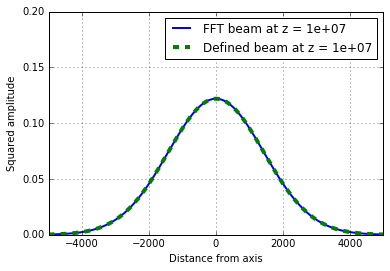

In [5]:
plt.plot(grid.px, np.abs(theory),            linewidth = 2, label = 'FFT beam at z = {0:0.0e}'.format(propDistance))
plt.plot(grid.px, np.abs(u2(grid.px)), '--', linewidth = 4, label = 'Defined beam at z = {0:0.0e}'.format(propDistance))
plt.xlim((-5000, 5000))
plt.ylim((0, 0.2))
plt.xlabel('Distance from axis')
plt.ylabel('Squared amplitude')
plt.grid(True)
plt.legend()
plt.show()

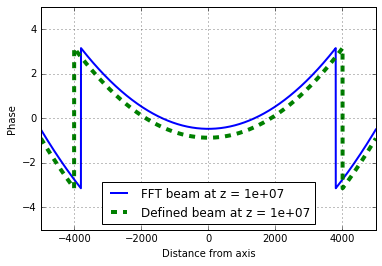

In [6]:
plt.plot(grid.px, np.angle(theory),            linewidth = 2, label = 'FFT beam at z = {0:0.0e}'.format(propDistance))
plt.plot(grid.px, np.angle(u2(grid.px)), '--', linewidth = 4, label = 'Defined beam at z = {0:0.0e}'.format(propDistance))
plt.xlim((-5000, 5000))
plt.ylim((-5, 5))
plt.xlabel('Distance from axis')
plt.ylabel('Phase')
plt.grid(True)
plt.legend(loc = 'lower center')
plt.show()

The difference between the FFT beam's phase and the phase of the beam defined in SimMLA comes down to the Guoy phase and will not be important here. This is because the Guoy phase is simply a constant phase offset for paraxial Gaussian beam.

In [7]:
from scipy.optimize import curve_fit

In [8]:
def Gaussian(x, *p):
    amp, std = p
    
    return amp * exp(-x**2 / 2 / std**2)
pinit   = [0.015, 3000]
popt, _ = curve_fit(Gaussian, grid.px, np.abs(u2(grid.px)), p0 = pinit)

In [9]:
print('The theoretical beam standard deviation is: {:.2f}'.format(w / np.sqrt(2)))
print('The SimMLA defined beam standard deviation is: {0:.2f}'.format(popt[1]))

The theoretical beam standard deviation is: 1429.69
The SimMLA defined beam standard deviation is: 1429.69


The check passes, which suggests that the angular spectrum propagation is working as expected. Let's now find the integrated power in the beam as another verification. The output power should match `power` above.

In [10]:
from scipy.integrate import simps

In [11]:
Irrad    = np.abs(u2(grid.px))**2 / Z0 * 1000
powerOut = simps(Irrad, grid.px)
print('The output power is {0:.2f} mW'.format(powerOut))

The output power is 100.00 mW
